In [26]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from transformers import LlamaTokenizer, LlamaForSequenceClassification, TrainingArguments, AutoTokenizer
from transformers import DataCollatorWithPadding, LlamaTokenizerFast
import torch
from torch.utils.data import Dataset
from transformers import pipeline
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import zipfile
from peft import LoraConfig, get_peft_model
from torch.cuda.amp import autocast
from ctransformers import AutoModelForCausalLM
from torch.optim.lr_scheduler import LambdaLR
import os

In [13]:
!kaggle competitions download -c dl-2025-study-competition-2

100%|██████████| 12.9M/12.9M [00:01<00:00, 10.4MB/s]


In [14]:
from kaggle.api.kaggle_api_extended import KaggleApi

with zipfile.ZipFile('dl-2025-study-competition-2.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/sample_submission.csv')  

In [15]:
print(train_df.shape,
      test_df.shape)
print(train_df.head())

(29568, 3) (7392, 2)
   id  ...                                   labels
0   0  ...  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1   1  ...  0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2   2  ...  0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3   3  ...  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4   4  ...  1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0

[5 rows x 3 columns]


In [16]:
train_df.dtypes

id         int64
text      object
labels    object
dtype: object

In [17]:
def convert_labels(label_str):
    """Преобразует строку с метками в список числовых значений"""
    return [int(x) for x in label_str.split()]

train_df['labels'] = train_df['labels'].apply(convert_labels)


In [18]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_df['labels'])
num_classes = y.shape[1]

X = train_df['text']
y = y  # Матрица меток

print("Форма матрицы признаков:", X.shape)
print("Форма матрицы меток:", y.shape)
print("Количество классов:", num_classes)
print("\nПример данных:")
print("Текст:", X.iloc[0])
print("Метки:", y[0])
print("Имена классов:", mlb.classes_)

Форма матрицы признаков: (29568,)
Форма матрицы меток: (29568, 2)
Количество классов: 2

Пример данных:
Текст: 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532
Метки: [1 1]
Имена классов: [0 1]


In [19]:
def clean_text(text):
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("Пример очищенного текста:")
print(train_df['cleaned_text'].iloc[0])

Пример очищенного текста:
15 января Детская развлекательная программа 15-00 бесплатно ❗️ @ cafeotdyh Кафе "Отдых" 📍 Запись обязательно +73472228532


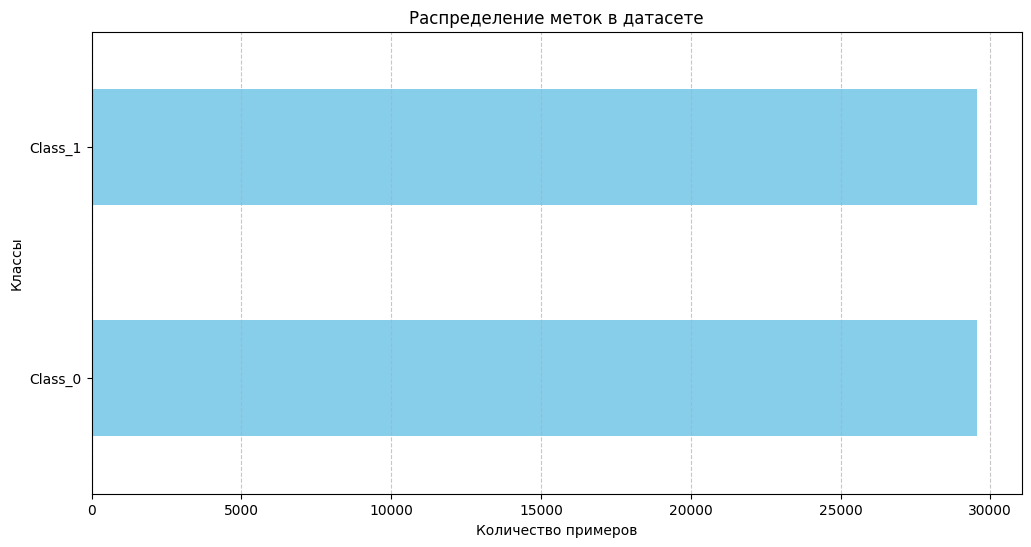

In [20]:
# Анализ распределения меток
label_counts = pd.Series(y.sum(axis=0), 
                        index=[f'Class_{i}' for i in range(y.shape[1])])

plt.figure(figsize=(12, 6))
label_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Распределение меток в датасете')
plt.xlabel('Количество примеров')
plt.ylabel('Классы')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

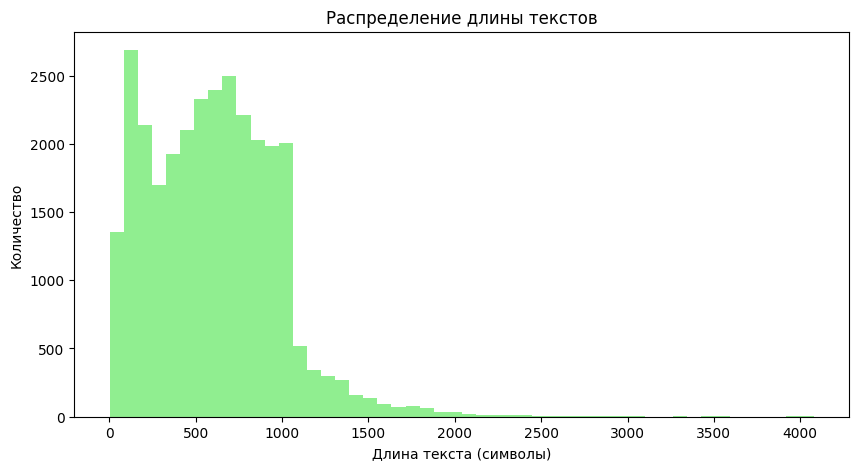

In [21]:
# Анализ длины текстов
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(train_df['text_length'], bins=50, color='lightgreen')
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.show()

# TF-IDF + Нейронная сеть

In [27]:
import nltk
nltk.download('punkt')  # Основные данные для word_tokenize
nltk.download('punkt_tab')  # Дополнительные таблицы для токенизации
nltk.download('stopwords')  # Для будущей очистки от стоп-слов
nltk.download('wordnet')  # Для лемматизации

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...


True

In [28]:
def tfidf_clean(text):
    # Удаление URL, дат (например, "13 января"), эмодзи
    text = re.sub(r'http\S+|www\S+|https\S+|[\d]{1,2}\s*[а-яА-Я]+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]|[\U0001F600-\U0001F64F]', '', text)  # Эмодзи и пунктуация
    
    text = text.lower()
    
    # Удаление стоп-слов и лемматизация
    stop_words = set(stopwords.words('russian'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

train_df['cleaned_tfidf'] = train_df['text'].apply(tfidf_clean)

# Word2Vec + Нейронная сеть

In [58]:
from nltk.tokenize import word_tokenize
def w2v_clean(text):
    # Удаление URL и специальных символов (но сохраняем пунктуацию для контекста)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[\d]{1,2}\s*[а-яА-Я]+', '', text)  # Даты
    
    # Токенизация без удаления стоп-слов (для сохранения контекста)
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]  # Только слова
    
    return ' '.join(tokens) 

train_df['cleaned_w2v'] = train_df['text'].apply(w2v_clean)

# CNN со встроенным эмбеддингом

In [59]:
def cnn_clean(text):
    # Удаление URL, но сохранение пунктуации и чисел
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Только эмодзи
    
    # Токенизация с сохранением пунктуации для n-грамм
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in ['«', '»', '...']]  # Частые "мусорные" символы
    
    return ' '.join(tokens)

train_df['cleaned_cnn'] = train_df['text'].apply(cnn_clean)

# RNN со встроенным эмбеддингом

In [60]:
def rnn_clean(text):
    # Удаление URL и дат
    text = re.sub(r'http\S+|www\S+|https\S+|[\d]{1,2}\s*[а-яА-Я]+', '', text)
    
    # Удаление редких символов, но сохранение пунктуации
    text = re.sub(r'[^\w\s.,!?]', '', text)
    
    # Токенизация с ограничением длины
    tokens = word_tokenize(text.lower())
    tokens = tokens[:100]  # Ограничение длины для RNN
    
    return ' '.join(tokens)

train_df['cleaned_rnn'] = train_df['text'].apply(rnn_clean)

# LLaMa

In [33]:
def llama_clean(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text)  # Замена URL на специальный токен
    text = re.sub(r'[\d]{1,2}\s*[а-яА-Я]+', '[DATE]', text)    # Даты
    return text.strip()  # Без токенизации!

train_df['cleaned_llama'] = train_df['text'].apply(llama_clean)

# Пайплайн

In [61]:
pipelines = {
    'tfidf': tfidf_clean,
    'w2v': w2v_clean,
    'cnn': cnn_clean,
    'rnn': rnn_clean,
    'llama': llama_clean
}

for name, pipeline in pipelines.items():
    train_df[f'cleaned_{name}'] = train_df['text'].apply(pipeline)
    test_df[f'cleaned_{name}'] = test_df['text'].apply(pipeline)

In [35]:
print(train_df.head())

   id  ...                                      cleaned_llama
0   0  ...  [DATE]\nДетская развлекательная программа\n15-...
1   1  ...    [DATE] [DATE]\nВыходные в Меге\n[URL]\nМегапарк
2   2  ...  Йокнапатофа\nПостановка Театр им. Маяковского\...
3   3  ...  Впервые в Уфе танцевальная терапия в группе с ...
4   4  ...  🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...

[5 rows x 10 columns]


In [36]:
train_df.columns

Index(['id', 'text', 'labels', 'cleaned_text', 'text_length', 'cleaned_tfidf',
       'cleaned_w2v', 'cleaned_cnn', 'cleaned_rnn', 'cleaned_llama'],
      dtype='object')

# Обучение

In [37]:
def get_callbacks(model_name):
    return [
        EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
        LearningRateScheduler(lambda epoch, lr: lr * 0.95 if epoch > 5 else lr)
    ]

In [38]:
from tensorflow.keras import backend as K

def macro_f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    macro_f1 = K.mean(f1)
    return macro_f1

In [40]:
def labels_to_matrix(labels_series):
    """
    Преобразует список списков в numpy array
    (уже не нужно использовать split, так как данные уже в виде списков)
    """
    return np.array([list(map(int, lst)) for lst in labels_series])

labels = labels_to_matrix(train_df['labels'])
X = train_df
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

## TF-IDF + НН

In [159]:
print("Training TF-IDF + NN...")
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train['text'].apply(tfidf_clean))
X_val_tfidf = tfidf.transform(X_val['text'].apply(tfidf_clean))

tfidf_nn = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(labels.shape[1], activation='sigmoid')
])

tfidf_nn.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', macro_f1]
)

history_tfidf = tfidf_nn.fit(
    X_train_tfidf.toarray(), y_train,
    validation_data=(X_val_tfidf.toarray(), y_val),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks('tfidf_nn')
)

Training TF-IDF + NN...
Epoch 1/20
365/370 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.0085 - macro_f1: 0.6915

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 7s 15ms/step - loss: 0.3125 - accuracy: 0.0087 - macro_f1: 0.6922 - val_loss: 0.2273 - val_accuracy: 0.0157 - val_macro_f1: 0.7511 - lr: 0.0010
Epoch 2/20
365/370 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.0182 - macro_f1: 0.7748

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 5s 14ms/step - loss: 0.1958 - accuracy: 0.0183 - macro_f1: 0.7748 - val_loss: 0.2037 - val_accuracy: 0.0162 - val_macro_f1: 0.7753 - lr: 0.0010
Epoch 3/20
365/370 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.0165 - macro_f1: 0.8088

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 5s 14ms/step - loss: 0.1545 - accuracy: 0.0164 - macro_f1: 0.8085 - val_loss: 0.1995 - val_accuracy: 0.0162 - val_macro_f1: 0.7915 - lr: 0.0010
Epoch 4/20
370/370 [==============================] - 2s 5ms/step - loss: 0.1263 - accuracy: 0.0168 - macro_f1: 0.8304 - val_loss: 0.2057 - val_accuracy: 0.0149 - val_macro_f1: 0.7939 - lr: 0.0010
Epoch 5/20
370/370 [==============================] - 2s 5ms/step - loss: 0.1059 - accuracy: 0.0176 - macro_f1: 0.8467 - val_loss: 0.2119 - val_accuracy: 0.0162 - val_macro_f1: 0.7937 - lr: 1.0000e-04
Epoch 6/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0810 - accuracy: 0.0195 - macro_f1: 0.8660 - val_loss: 0.2129 - val_accuracy: 0.0178 - val_macro_f1: 0.8007 - lr: 1.0000e-04


## Word2Vec + HH

In [50]:
sentences = X_train['text'].tolist()

print("Training Word2Vec...")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

class W2VEmbedding:
    def __init__(self, w2v_model):
        self.w2v = w2v_model

    def embed(self, texts):
        embeddings = []
        for text in texts:
            # Для каждого текста получаем вектора слов и усредняем
            word_vectors = [self.w2v.wv[word] for word in text if word in self.w2v.wv]
            if len(word_vectors) == 0:
                embeddings.append(np.zeros(100))
            else:
                embeddings.append(np.mean(word_vectors, axis=0))
        return np.array(embeddings)

print("Creating embeddings...")
embedder = W2VEmbedding(w2v_model)
X_train_w2v = embedder.embed(X_train['text'])
X_val_w2v = embedder.embed(X_val['text'])

print("Building NN model...")
w2v_nn = Sequential([
    Dense(256, activation='relu', input_shape=(100,)),
    Dropout(0.5),
    Dense(labels.shape[1], activation='sigmoid')
])

w2v_nn.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', macro_f1]
)

print("Training NN...")
history = w2v_nn.fit(
    X_train_w2v, y_train,
    validation_data=(X_val_w2v, y_val),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks('w2v_nn')
)

Training Word2Vec...
Creating embeddings...
Building NN model...
Training NN...
Epoch 1/20
353/370 [===========================>..] - ETA: 0s - loss: 0.4352 - accuracy: 0.0254 - macro_f1: 0.6587

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 2s 3ms/step - loss: 0.4333 - accuracy: 0.0257 - macro_f1: 0.6598 - val_loss: 0.3805 - val_accuracy: 0.0299 - val_macro_f1: 0.6909 - lr: 0.0010
Epoch 2/20
370/370 [==============================] - 1s 3ms/step - loss: 0.3754 - accuracy: 0.0259 - macro_f1: 0.6935 - val_loss: 0.3495 - val_accuracy: 0.0340 - val_macro_f1: 0.7099 - lr: 0.0010
Epoch 3/20
 22/370 [>.............................] - ETA: 0s - loss: 0.3616 - accuracy: 0.0348 - macro_f1: 0.6994

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3551 - accuracy: 0.0274 - macro_f1: 0.7063 - val_loss: 0.3377 - val_accuracy: 0.0232 - val_macro_f1: 0.7130 - lr: 0.0010
Epoch 4/20
  1/370 [..............................] - ETA: 1s - loss: 0.3634 - accuracy: 0.0312 - macro_f1: 0.7080

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3427 - accuracy: 0.0274 - macro_f1: 0.7139 - val_loss: 0.3255 - val_accuracy: 0.0309 - val_macro_f1: 0.7248 - lr: 0.0010
Epoch 5/20
 43/370 [==>...........................] - ETA: 0s - loss: 0.3366 - accuracy: 0.0211 - macro_f1: 0.7158

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3353 - accuracy: 0.0276 - macro_f1: 0.7175 - val_loss: 0.3173 - val_accuracy: 0.0338 - val_macro_f1: 0.7266 - lr: 0.0010
Epoch 6/20
  1/370 [..............................] - ETA: 1s - loss: 0.3214 - accuracy: 0.0156 - macro_f1: 0.7274

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3301 - accuracy: 0.0279 - macro_f1: 0.7208 - val_loss: 0.3115 - val_accuracy: 0.0330 - val_macro_f1: 0.7338 - lr: 0.0010
Epoch 7/20
 43/370 [==>...........................] - ETA: 0s - loss: 0.3270 - accuracy: 0.0262 - macro_f1: 0.7240

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3233 - accuracy: 0.0276 - macro_f1: 0.7251 - val_loss: 0.3068 - val_accuracy: 0.0238 - val_macro_f1: 0.7336 - lr: 9.5000e-04
Epoch 8/20
  1/370 [..............................] - ETA: 1s - loss: 0.3072 - accuracy: 0.0469 - macro_f1: 0.7507

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


360/370 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.0275 - macro_f1: 0.7264

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3201 - accuracy: 0.0276 - macro_f1: 0.7264 - val_loss: 0.3041 - val_accuracy: 0.0208 - val_macro_f1: 0.7364 - lr: 9.0250e-04
Epoch 9/20
370/370 [==============================] - 1s 3ms/step - loss: 0.3170 - accuracy: 0.0266 - macro_f1: 0.7281 - val_loss: 0.3005 - val_accuracy: 0.0265 - val_macro_f1: 0.7373 - lr: 8.5737e-04
Epoch 10/20
 22/370 [>.............................] - ETA: 0s - loss: 0.3144 - accuracy: 0.0206 - macro_f1: 0.7271

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/370 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.0288 - macro_f1: 0.7306

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3134 - accuracy: 0.0287 - macro_f1: 0.7302 - val_loss: 0.2983 - val_accuracy: 0.0228 - val_macro_f1: 0.7353 - lr: 8.1451e-04
Epoch 11/20
370/370 [==============================] - 1s 3ms/step - loss: 0.3108 - accuracy: 0.0287 - macro_f1: 0.7313 - val_loss: 0.2960 - val_accuracy: 0.0223 - val_macro_f1: 0.7363 - lr: 7.7378e-04
Epoch 12/20
  1/370 [..............................] - ETA: 1s - loss: 0.3126 - accuracy: 0.0625 - macro_f1: 0.7253

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3093 - accuracy: 0.0293 - macro_f1: 0.7317 - val_loss: 0.2939 - val_accuracy: 0.0306 - val_macro_f1: 0.7416 - lr: 7.3509e-04
Epoch 13/20
 22/370 [>.............................] - ETA: 0s - loss: 0.3067 - accuracy: 0.0241 - macro_f1: 0.7340

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3056 - accuracy: 0.0306 - macro_f1: 0.7341 - val_loss: 0.2942 - val_accuracy: 0.0294 - val_macro_f1: 0.7383 - lr: 6.9834e-04
Epoch 14/20
370/370 [==============================] - 1s 3ms/step - loss: 0.3052 - accuracy: 0.0320 - macro_f1: 0.7336 - val_loss: 0.2908 - val_accuracy: 0.0357 - val_macro_f1: 0.7423 - lr: 6.6342e-04
Epoch 15/20
 43/370 [==>...........................] - ETA: 0s - loss: 0.3029 - accuracy: 0.0360 - macro_f1: 0.7375

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3035 - accuracy: 0.0327 - macro_f1: 0.7357 - val_loss: 0.2883 - val_accuracy: 0.0372 - val_macro_f1: 0.7453 - lr: 6.3025e-04
Epoch 16/20
  1/370 [..............................] - ETA: 1s - loss: 0.3023 - accuracy: 0.0625 - macro_f1: 0.7252

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3017 - accuracy: 0.0349 - macro_f1: 0.7361 - val_loss: 0.2868 - val_accuracy: 0.0384 - val_macro_f1: 0.7422 - lr: 5.9874e-04
Epoch 17/20
 43/370 [==>...........................] - ETA: 0s - loss: 0.2971 - accuracy: 0.0316 - macro_f1: 0.7393

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


358/370 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.0347 - macro_f1: 0.7375

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.3002 - accuracy: 0.0344 - macro_f1: 0.7372 - val_loss: 0.2863 - val_accuracy: 0.0367 - val_macro_f1: 0.7452 - lr: 5.6880e-04
Epoch 18/20
370/370 [==============================] - 1s 3ms/step - loss: 0.2986 - accuracy: 0.0348 - macro_f1: 0.7369 - val_loss: 0.2849 - val_accuracy: 0.0377 - val_macro_f1: 0.7465 - lr: 5.4036e-04
Epoch 19/20
 22/370 [>.............................] - ETA: 0s - loss: 0.2911 - accuracy: 0.0362 - macro_f1: 0.7405

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 1s 3ms/step - loss: 0.2975 - accuracy: 0.0349 - macro_f1: 0.7376 - val_loss: 0.2857 - val_accuracy: 0.0375 - val_macro_f1: 0.7435 - lr: 5.1334e-04
Epoch 20/20
370/370 [==============================] - 1s 3ms/step - loss: 0.2968 - accuracy: 0.0360 - macro_f1: 0.7389 - val_loss: 0.2855 - val_accuracy: 0.0370 - val_macro_f1: 0.7418 - lr: 4.8767e-05


## CNN со встроенным эмбеддингом

In [69]:
print("Training CNN with Embedding...")
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train['text'].apply(cnn_clean))

X_train_cnn = pad_sequences(
    tokenizer.texts_to_sequences(X_train['text'].apply(cnn_clean)),
    maxlen=100,
    padding='post'
)
X_val_cnn = pad_sequences(
    tokenizer.texts_to_sequences(X_val['text'].apply(cnn_clean)),
    maxlen=100,
    padding='post'
)

cnn_model = Sequential([
    Embedding(10000, 128, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(labels.shape[1], activation='sigmoid')
])

cnn_model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', macro_f1]
)

history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks('cnn_model')
)

Training CNN with Embedding...
Epoch 1/20
370/370 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.0144 - macro_f1: 0.6882

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 31s 63ms/step - loss: 0.3208 - accuracy: 0.0144 - macro_f1: 0.6882 - val_loss: 0.2420 - val_accuracy: 0.0188 - val_macro_f1: 0.7417 - lr: 0.0010
Epoch 2/20
370/370 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.0184 - macro_f1: 0.7608

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 9s 26ms/step - loss: 0.2057 - accuracy: 0.0184 - macro_f1: 0.7608 - val_loss: 0.2012 - val_accuracy: 0.0169 - val_macro_f1: 0.7692 - lr: 0.0010
Epoch 3/20
370/370 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.0182 - macro_f1: 0.7936

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 6s 17ms/step - loss: 0.1591 - accuracy: 0.0182 - macro_f1: 0.7936 - val_loss: 0.1846 - val_accuracy: 0.0166 - val_macro_f1: 0.7793 - lr: 0.0010
Epoch 4/20
370/370 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.0178 - macro_f1: 0.8193

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 4s 11ms/step - loss: 0.1241 - accuracy: 0.0178 - macro_f1: 0.8193 - val_loss: 0.1777 - val_accuracy: 0.0154 - val_macro_f1: 0.7923 - lr: 0.0010
Epoch 5/20
370/370 [==============================] - 3s 9ms/step - loss: 0.0955 - accuracy: 0.0186 - macro_f1: 0.8416 - val_loss: 0.1777 - val_accuracy: 0.0159 - val_macro_f1: 0.7944 - lr: 0.0010
Epoch 6/20
370/370 [==============================] - 3s 9ms/step - loss: 0.0725 - accuracy: 0.0177 - macro_f1: 0.8610 - val_loss: 0.1845 - val_accuracy: 0.0161 - val_macro_f1: 0.7978 - lr: 1.0000e-04
Epoch 7/20
370/370 [==============================] - 3s 7ms/step - loss: 0.0507 - accuracy: 0.0182 - macro_f1: 0.8795 - val_loss: 0.1811 - val_accuracy: 0.0161 - val_macro_f1: 0.8012 - lr: 9.5000e-05


## RNN со встроенным эмбеддингом

In [73]:
print("Training RNN with Embedding...")

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train['text'].apply(rnn_clean))

X_train_rnn = pad_sequences(
    tokenizer.texts_to_sequences(X_train['text'].apply(rnn_clean)),
    maxlen=100,
    padding='post',
    truncating='post'
)

X_val_rnn = pad_sequences(
    tokenizer.texts_to_sequences(X_val['text'].apply(rnn_clean)),
    maxlen=100,
    padding='post',
    truncating='post'
)

rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(units=labels.shape[1], activation='sigmoid')
])

rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', macro_f1] 
)

history_rnn = rnn_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=20,
    batch_size=64,
    callbacks=get_callbacks('rnn_model')
)


Training RNN with Embedding...
Epoch 1/20
370/370 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.0052 - macro_f1: 0.6673

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 29s 68ms/step - loss: 0.3511 - accuracy: 0.0052 - macro_f1: 0.6673 - val_loss: 0.2884 - val_accuracy: 0.0042 - val_macro_f1: 0.7165 - lr: 0.0010
Epoch 2/20
370/370 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.0041 - macro_f1: 0.7339

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 11s 31ms/step - loss: 0.2588 - accuracy: 0.0041 - macro_f1: 0.7339 - val_loss: 0.2526 - val_accuracy: 0.0069 - val_macro_f1: 0.7400 - lr: 0.0010
Epoch 3/20
370/370 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.0042 - macro_f1: 0.7536

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 8s 21ms/step - loss: 0.2233 - accuracy: 0.0042 - macro_f1: 0.7536 - val_loss: 0.2345 - val_accuracy: 0.0076 - val_macro_f1: 0.7483 - lr: 0.0010
Epoch 4/20
370/370 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.0043 - macro_f1: 0.7692

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 6s 16ms/step - loss: 0.1958 - accuracy: 0.0043 - macro_f1: 0.7692 - val_loss: 0.2248 - val_accuracy: 0.0059 - val_macro_f1: 0.7601 - lr: 0.0010
Epoch 5/20
370/370 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.0042 - macro_f1: 0.7826

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


370/370 [==============================] - 5s 13ms/step - loss: 0.1732 - accuracy: 0.0042 - macro_f1: 0.7826 - val_loss: 0.2184 - val_accuracy: 0.0054 - val_macro_f1: 0.7605 - lr: 0.0010
Epoch 6/20
370/370 [==============================] - 4s 11ms/step - loss: 0.1530 - accuracy: 0.0041 - macro_f1: 0.7933 - val_loss: 0.2194 - val_accuracy: 0.0056 - val_macro_f1: 0.7630 - lr: 0.0010
Epoch 7/20
370/370 [==============================] - 5s 13ms/step - loss: 0.1352 - accuracy: 0.0041 - macro_f1: 0.8029 - val_loss: 0.2212 - val_accuracy: 0.0054 - val_macro_f1: 0.7684 - lr: 9.5000e-05
Epoch 8/20
370/370 [==============================] - 4s 12ms/step - loss: 0.1136 - accuracy: 0.0043 - macro_f1: 0.8147 - val_loss: 0.2218 - val_accuracy: 0.0052 - val_macro_f1: 0.7720 - lr: 9.0250e-05


## LLaMa

In [105]:
from huggingface_hub import hf_hub_download

In [144]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [156]:
train_df, val_df = train_test_split(X.join(pd.DataFrame(labels, columns=[f"label_{i}" for i in range(labels.shape[1])])), 
                                    test_size=0.2, random_state=42)

model_path = hf_hub_download(
    repo_id="TheBloke/Mistral-7B-Instruct-v0.2-GGUF",
    filename="mistral-7b-instruct-v0.2.Q4_K_M.gguf",  # Оптимальный вариант
    resume_download=True
)

tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.2-AWQ")

model = Llama(
    model_path=model_path,
    n_ctx=2048,  # Размер контекста
    n_threads=8  # Количество CPU-потоков
)

class LlamaClassificationDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['cleaned_llama']
        labels = row['labels']
        
        prompt = f"""<s>[INST] Classify this text: {text} [/INST]"""
        
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

train_dataset = LlamaClassificationDataset(train_df, tokenizer)
val_dataset = LlamaClassificationDataset(val_df, tokenizer)

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /tmp/xdg_cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_mode

In [142]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda, last_epoch)


class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_metric = -np.inf
        self.early_stopping_patience = 3
        self.no_improvement_count = 0

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Свитч между loss функциями
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                       labels.float().view(-1, self.model.config.num_labels))

        return (loss, outputs) if return_outputs else loss

    def evaluation_step(self, model, inputs):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            loss, outputs = self.compute_loss(model, inputs, return_outputs=True)
        logits = outputs.logits
        preds = (torch.sigmoid(logits) > 0.5).int()
        return {"loss": loss, "preds": preds, "labels": inputs["labels"]}

    def evaluate(self, eval_dataset=None, ignore_keys=None):
        eval_output = super().evaluate(eval_dataset, ignore_keys)

        preds = torch.cat([x["preds"] for x in eval_output.predictions])
        labels = torch.cat([x["labels"] for x in eval_output.predictions])

        macro_f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        accuracy = accuracy_score(labels.cpu(), preds.cpu())

        eval_output.metrics.update({
            "eval_macro_f1": macro_f1,
            "eval_accuracy": accuracy
        })

        # Ранняя остановка по macro F1
        if macro_f1 > self.best_metric:
            self.best_metric = macro_f1
            self.no_improvement_count = 0
            self.save_model(os.path.join(self.args.output_dir, "best_model"))
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.early_stopping_patience:
                self.control.should_training_stop = True

        return eval_output

In [152]:
def prepare_prompt(text, labels=None):
    labels_str = " ".join(map(str, labels)) if labels else ""
    
    prompt = f"""<s>[INST] Классифицируй текст по меткам:
Текст: {text}
Метки: {labels_str} [/INST]"""
    return prompt

train_prompts = [prepare_prompt(row['text'], row['labels']) 
                for _, row in train_df.iterrows()]
total_steps = len(train_prompts) * 5 // 2  # epochs * len(dataset) // batch_size
warmup_steps = int(0.1 * total_steps)

# training_args = TrainingArguments(
#     output_dir="./mistral-finetuned",
#     learning_rate=3e-5,
#     num_train_epochs=5,
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     gradient_accumulation_steps=4,
#     optim="adamw_torch",
#     fp16=True,
#     logging_steps=10,
#     save_steps=500,
#     eval_strategy="steps",
#     eval_steps=100,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_macro_f1",
#     greater_is_better=True,
#     warmup_steps=warmup_steps,  # Вормап
#     lr_scheduler_type="linear",  # Шедулер
#     save_total_limit=2,
# )

trainer = CustomTrainer(
    model=llm,
    # args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        "macro_f1": f1_score(p.label_ids, p.predictions > 0.5, average="macro"),  # Изменено
        "accuracy": accuracy_score(p.label_ids, p.predictions > 0.5)
    },
    optimizers=(None, get_linear_schedule_with_warmup(
        optimizer=torch.optim.AdamW(llm.parameters(), lr=3e-5),
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    ))
)

trainer.train()

best_model = AutoModelForCausalLM.from_pretrained(
    os.path.join(training_args.output_dir, "best_model"),
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_4bit=True  # Квантование для экономии памяти

)

AttributeError: 'Llama' object has no attribute 'parameters'

# Сохранение предсказаний в submission с настройкой порога для предсказаний

In [162]:
from sklearn.metrics import f1_score

val_probs = tfidf_nn.predict(
    X_val_tfidf.toarray()
)

thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    binary_preds = (val_probs > threshold).astype(int)
    
    current_f1 = f1_score(y_val, binary_preds, average='macro')
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold:.2f}, F1-score: {best_f1:.4f}')

X_test_tfidf = tfidf.transform(test_df['text'].apply(tfidf_clean))

test_probs = tfidf_nn.predict(X_test_tfidf.toarray())
final_predictions = (test_probs > best_threshold).astype(int)

test_df['labels'] = [' '.join(map(str, pred)) for pred in final_predictions]

submission_df = test_df[['id', 'labels']]  
submission_df.to_csv('submission.csv', index=False)

185/185 [==============================] - 0s 1ms/step
Best threshold: 0.30, F1-score: 0.8188
231/231 [==============================] - 0s 1ms/step


In [ ]:
# X_test_tfidf = tfidf.transform(test_df['text'].apply(tfidf_clean))

# test_predictions = tfidf_nn.predict(X_test_tfidf.toarray())

# binary_predictions = (test_predictions > 0.25).astype(int)

# test_df['labels'] = [' '.join(map(str, pred)) for pred in binary_predictions]

# submission_df = test_df[['id', 'labels']]  
# submission_df.to_csv('submission.csv', index=False)